## SENEKAL

--------------------------------------------------
### DIFFUSION ANALYSIS


Diffusion analysis is the study of how interpersonal ties amplify the spread of a product, idea, or innovation such that a change in one person's behaviour cascades through a social network and produces a behavioural change in other people, communities, and populations.

#### Data Source


*#Senekal Reply Network - Largest Component*



#### Data Transformation


Using the timestamp of when a tweet is created, I define the interaction point for node *A* and node *B* to be the point in time when either node *A* first replies to node *B* or vice versa. Any time before that point, a connection between node *A* and node *B* does not exist, and any time after that, a connection between node *A* and node *B* exists. I classify an undirected dynamic network where an "infection" can be transmitted in either direction and the choice to adopt is faced by either one (sender or receiver). Therefore, at any point when node *A* replies to node *B*, node *A* is aware of node *B*'s message, and at the same time, by directly replying to node *B*, node *B* is made aware of node *A*'s message. Once exposed, both are susceptible to "infection" and their decision to adopt is a combined function of their *threshold* to resist peer pressure and their personal *profile* or preference to only adopt when their interests are aligned.


#### Default Parameters


Threshold ($\tau$) = 60%

Profile ($\gamma$) = 25%  

For each simulation, I assume a passive threshold of 60% and active threshold of 25%. This means for any node to be susceptible, 60% of its neighbours should already be infected. Once this condition is met, a random number is drawn, if that number is above 25%, a node becomes infected. Initial adopters or seeds are selected from the top of each role list. Given the dynamic process, users eligible for seed selection are constrained by the date and time of their first tweet reply. An upper limit of 6 initial seeds is chosen for each simulation. Which means, depending on the diffusion period, each simulation can have up to 6 users as initial adopters.


#### Method



Using pythons ndlib and dynetx library, I present the dynamic **profile threshold model** and determine the diffusion process of discourse under varying seeds of adoption.

In [1]:
#
#import import_ipynb
#import os
import pandas as pd
import numpy as np
from scipy import stats
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import ipyplot
import plotly.express as px
from operator import itemgetter
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator
import random
from numpy import random as nprando
from datetime import datetime, date, time, timedelta
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
from ndlib.viz.mpl.PrevalenceComparison import DiffusionPrevalenceComparison
#from bokeh.io import output_notebook, show
#from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
#from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
#from ndlib.viz.bokeh.MultiPlot import MultiPlot
import dynetx as dn
import ndlib.models.dynamic as dm
#import plotly.graph_objects as go
from IPython.display import Image, SVG, HTML, display
#from svglib.svglib import svg2rlg
#from reportlab.graphics import renderPM

#########################################################################################

##SETUP##
%matplotlib inline
sns.set()
nprando.seed(111)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (12, 8)})
pd.set_option("display.max_columns",None)

##FUNCTIONS##
# Sort index order
def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s


# Independent Cascade Model
def ic(G,s,d=[], a=[]):
    #print(s)
    jst_inf=list(s)
    infected=list(s)
    #flag = True
    while(1):
        #print(jst_inf, infected)
        # iteration ends when jst_infected list becomes empty
        if len(jst_inf)==0:
            return infected
            #flag = False
        tmp=[]
        for each in jst_inf:
            for each1 in G.neighbors(each, mode='all'):
                r = random.uniform(0,1)
                # if node in spreader role, do not infect node
                if each1 in d:
                    r=0
                # if node in activator role, do not infect node
                if each1 in a:
                    r=0    
                # if node has random number less than 0.5, infect node
                if r>0.5 and each1 not in infected and each1 not in tmp:
                    tmp.append(each1)
            # overall infected nodes
            infected.append(each)
        # infected nodes in current iteration
        jst_inf=list(tmp)

##VARIABLES##
e_node = "senekal_nodes_1.csv"
e_kmean = "senekal_kmeans_1.csv"
e_vcomm = "senekal_vcomm_1_a.csv"
e_ecomm = "senekal_ecomm_1_a.csv"
e_edge = "senekal_edges_1.csv"
n=20
adopt = 0
block = 0
infect = 0.01
profile = 0.25
threshold = 0.6

#########################################################################################

##LOAD DATA##
df_node_1 = pd.read_csv(e_node, sep=";", dtype={'id': str})
#df_node_1.describe()  
df_edge_1 = pd.read_csv(e_edge, sep=";", dtype={'source': str, 'target': str, 'weight':int})
#df_edge_1.describe()
df_kmean_1 = pd.read_csv(e_kmean, sep=";", dtype={'id': str})
#df_kmean_1.describe()
df_vcomm_1 = pd.read_csv(e_vcomm, sep=",", dtype={'Id': str})
df_vcomm_1 = df_vcomm_1.rename(columns={"Id": "id", 'Label':"label"})
#df_vcomm_1.describe()  
df_ecomm_1 = pd.read_csv(e_ecomm, sep=",", dtype={'Source': str, 'Target': str, 'Weight':int})
df_ecomm_1 = df_ecomm_1.rename(columns={"Source": "source_", 'Target':"target_", 'Weight':"weight"})
#df_ecomm_1.describe()

##CONVERT TO UNDIRECTED GRAPH
#G_nx = nx.from_pandas_edgelist(df_edge_1, source='source', target='target', edge_attr=True, create_using=nx.DiGraph())
#G_nx = nx.from_pandas_edgelist(df_edge_1, source='source', target='target', edge_attr=True, create_using=nx.DiGraph())
#node_1 = df_node_1.set_index('id').to_dict('index')
#nx.set_node_attributes(G_nx, node_1)

# CONVERT TO DIRECTED IGRAPH
G_ig=ig.Graph.DictList(df_node_1.to_dict('records'), df_edge_1.to_dict('records'), directed=True, vertex_name_attr='id', edge_foreign_keys=('source', 'target'))
#print("\n" + "--------" + "\n" + '\033[1m' + 'Directed Network:' + '\033[0m' + "\n")
#print(ig.summary(G_ig))

##

no display found. Using non-interactive Agg backend
no display found. Using non-interactive Agg backend



--------
Number of Daily Interactions (Tweet Replies) in #Senekal Discourse:



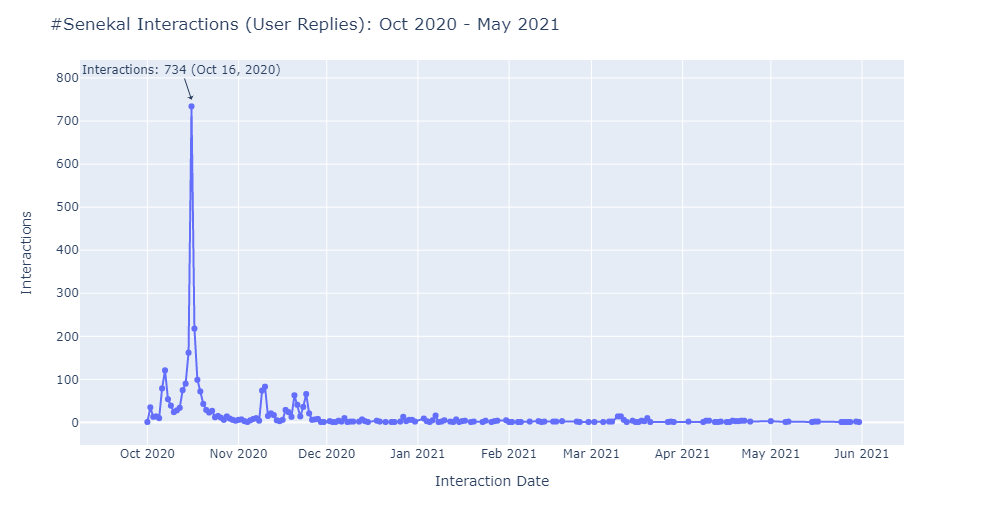

In [2]:
##CONVERT TO DYNAMIC IGRAPH
#DAILY SNAPSHOTS
d_node = df_node_1['date_tweet'].fillna("").to_list()
d_edge = df_edge_1['date_tweet'].fillna("").to_list()


e_date_lst =[]
for each in d_edge:    
    dt_lst=list(each.split(','))
    #print(dt_lst)
    edates = list(filter(None, dt_lst))
    edates = sorted(edates, key=lambda edates: datetime.strptime(edates, '%Y-%m-%d'))
    d_e_1 = datetime.strptime(edates[0], '%Y-%m-%d')
    #print(d_e_1)
    e_date_lst.append(d_e_1)
       

df_edge_1['date_edt_1'] = list(map(lambda x:x.strftime('%Y-%m-%d'),e_date_lst))
e_time = sorted(set(e_date_lst), key=lambda e_date_lst: e_date_lst)
e_time_x = list(map(lambda x:x.strftime('%Y-%m-%d'),e_time)) 
#print(e_time_x)


##CONVERT TO DYNAMIC GRAPH##
G_dn0 = dn.DynGraph()
#G_dn = dn.DynDiGraph()
 
#dyn_edge = []
for i, t in enumerate(e_time_x):
    if datetime.strptime(t, '%Y-%m-%d') >= datetime.strptime("2020-10-01", '%Y-%m-%d') and datetime.strptime(t, '%Y-%m-%d') <= datetime.strptime("2021-05-31", '%Y-%m-%d'):
        #print(t)
        df_et=df_edge_1.loc[df_edge_1['date_edt_1']==t]
        #print(df_et)
        dyn_edge = df_et[['source','target']].to_records(index=False)
        G_dn0.add_interactions_from(dyn_edge, t=i)

        
#INTERACTION PLOT
#print(G_dn0.number_of_interactions())
dict_snap = G_dn0.interactions_per_snapshots()
#print(dict_snap)
inter_lst = list(dict_snap.keys())

dict_e_dt = {e:t for e,t in enumerate(e_time_x)}
#print(dict_e_dt)
#edge_date = e_time_x
#print(edge_date)


edge_date = []
for e,t in dict_e_dt.items():
    for k,i in dict_snap.items():
        if e==k:
            edge_date.append(t)

edge_inter = list(dict_snap.values()) 

#print(len(edge_inter))
#print(len(edge_date))

print("\n" + "--------" + "\n" + '\033[1m' + 'Number of Daily Interactions (Tweet Replies) in #Senekal Discourse:' + '\033[0m' + "\n")
   
#plt.rcParams["figure.figsize"]=[8,4]
#plt.rcParams["figure.autolayout"] =True
#fig = px.line(x=edge_date,y=edge_inter, markers=True)
#fig.update_layout(xaxis_title= 'Interaction Date', yaxis_title= 'Interactions',  title = '#Senekal Interactions (User Replies): Oct 2020 - May 2021')
#fig.add_annotation(x='2020-10-16', y=750, text="Interactions: 734 (Oct 16, 2020)", showarrow=True, arrowhead=1)
#plt.savefig("senekal_interactions_1.png")
#fig.show()



#dn.write_interactions(G_dn, senekal_dyn_1)
Image(filename="senekal_interactions_1.png",  width = "650")
 

In [8]:
#FULL DAILY SNAPSHOTS
d_node = df_node_1['date_tweet'].fillna("").to_list()
d_edge = df_edge_1['date_tweet'].fillna("").to_list()

d_edge_lst = []
edates_16 = []
e_date_lst =[]
for each in d_edge:    
    dt_lst=list(each.split(','))
    #print(dt_lst)
    edates = list(filter(None, dt_lst))  
    edates = sorted(edates, key=lambda edates: datetime.strptime(edates, '%Y-%m-%d'))
    d_e_1 = datetime.strptime(edates[0], '%Y-%m-%d')
        #print(d_e_1)
    e_date_lst.append(d_e_1)
#print(e_date_lst)     

df_edge_1['date_ed_1'] = list(map(lambda x:x.strftime('%Y-%m-%d'),e_date_lst))
e_time = sorted(set(e_date_lst), key=lambda e_date_lst: e_date_lst)
e_time_x = list(map(lambda x:x.strftime('%Y-%m-%d'),e_time)) 
#print(e_time_x)


##CONVERT TO DYNAMIC GRAPH##
G_dn1 = dn.DynGraph()
G_dn2 = dn.DynGraph()
G_dn3 = dn.DynGraph()
#G_dn = dn.DynDiGraph()
 
#dyn_edge = []
for i, t in enumerate(e_time_x):
    if datetime.strptime(t, '%Y-%m-%d') >= datetime.strptime("2020-10-01", '%Y-%m-%d') and datetime.strptime(t, '%Y-%m-%d') <= datetime.strptime("2021-05-31", '%Y-%m-%d'):
            #print(t)
        df_et=df_edge_1.loc[df_edge_1['date_ed_1']==t]
        #print(df_et)
        dyn_edge = df_et[['source','target']].to_records(index=False)
        G_dn1.add_interactions_from(dyn_edge, t=i)

#print(G_dn1.number_of_nodes(),G_dn1.number_of_interactions())
#2204 2660
        
for i, t in enumerate(e_time_x):
    if datetime.strptime(t, '%Y-%m-%d') >= datetime.strptime("2020-10-01", '%Y-%m-%d') and datetime.strptime(t, '%Y-%m-%d') < datetime.strptime("2020-10-16", '%Y-%m-%d'):
            #print(t)
        df_et2=df_edge_1.loc[df_edge_1['date_ed_1']==t]
        #print(df_et)
        dyn_edge2 = df_et2[['source','target']].to_records(index=False)
        G_dn2.add_interactions_from(dyn_edge2, t=i)

#print(G_dn2.number_of_nodes(),G_dn2.number_of_interactions()) 
#761 693
   
####  

In [20]:
#OCTOBER 16 SNAPSHOTS
d_node = df_node_1['datetime_tweet'].fillna("").to_list()
d_edge = df_edge_1['datetime_tweet'].fillna("").to_list()

d_edge_lst = []
edates_16 = []
e_date_lst =[]
for each in d_edge:    
    dt_lst=list(each.split(','))
    #print(dt_lst)
    edates = list(filter(None, dt_lst))  
    edates = sorted(edates, key=lambda edates: datetime.strptime(edates, '%b %d %Y %H:%M:%S'))
    d_e_1 = datetime.strptime(edates[0], '%b %d %Y %H:%M:%S')
        #print(d_e_1)
    e_date_lst.append(d_e_1)
#print(e_date_lst)    

df_edge_1['date_e_1'] = list(map(lambda x:x.strftime('%b %d %Y %H:%M:%S'),e_date_lst))
e_time = sorted(set(e_date_lst), key=lambda e_date_lst: e_date_lst)
e_time_x = list(map(lambda x:x.strftime('%b %d %Y %H:%M:%S'),e_time)) 
#print(e_time_x)


##CONVERT TO DYNAMIC GRAPH##
G_dn = dn.DynGraph()
#G_dn = dn.DynDiGraph()
 
dict_edge_2= []
for i, t in enumerate(e_time_x):
    if datetime.strptime(t, '%b %d %Y %H:%M:%S') >= datetime.strptime("Oct 16 2020 00:00:00", '%b %d %Y %H:%M:%S') and datetime.strptime(t, '%b %d %Y %H:%M:%S') <= datetime.strptime("Oct 17 2020 00:00:00", '%b %d %Y %H:%M:%S'):
            #print(t)
        df_et=df_edge_1.loc[df_edge_1['date_e_1']==t]
        #print(df_et)
        dyn_edge = df_et[['source','target']].to_records(index=False)
        G_dn.add_interactions_from(dyn_edge, t=i)
        dyn_edge_2 = df_et[['source','target','weight']].to_records(index=False)
        #print(dyn_edge_2)
        dict_edge_2.append(dyn_edge_2) 

#print(G_dn.number_of_nodes(),G_dn.number_of_interactions()) 
#712 674

# CONVERT TO DIRECTED IGRAPH
#print(dict_edge_2)
df_edge_2 = pd.DataFrame(dict_edge_2)
#print(df_edge_2)
#G_ig=ig.Graph.DictList(df_node_1.to_dict('records'), df_edge_1.to_dict('records'), directed=True, vertex_name_attr='id', edge_foreign_keys=('source', 'target'))
#print("\n" + "--------" + "\n" + '\033[1m' + 'Directed Network:' + '\033[0m' + "\n")
#print(ig.summary(G_ig))
    
    

[rec.array([('1248013261469110279', '111278246', 1)],
          dtype=[('source', 'O'), ('target', 'O'), ('weight', '<i4')]), rec.array([('1248013261469110279', '742823052354945024', 1)],
          dtype=[('source', 'O'), ('target', 'O'), ('weight', '<i4')]), rec.array([('90574714', '1287488216615059457', 1)],
          dtype=[('source', 'O'), ('target', 'O'), ('weight', '<i4')]), rec.array([('1261962628160724997', '485644333', 1)],
          dtype=[('source', 'O'), ('target', 'O'), ('weight', '<i4')]), rec.array([('337554845', '742681004', 1)],
          dtype=[('source', 'O'), ('target', 'O'), ('weight', '<i4')]), rec.array([('1273244075949535236', '3385822409', 1)],
          dtype=[('source', 'O'), ('target', 'O'), ('weight', '<i4')]), rec.array([('713767983907217408', '1015558713715953664', 1)],
          dtype=[('source', 'O'), ('target', 'O'), ('weight', '<i4')]), rec.array([('309201798', '14697575', 1)],
          dtype=[('source', 'O'), ('target', 'O'), ('weight', '<i4')]), re

In [5]:
# Parameters
role=['Leader','Activator','Spreader','Observer']
n_lst = G_dn.nodes()
n2_lst = G_dn2.nodes()

df_l=df_kmean_1.sort_values(by=['pagerank', 'indegree', '#liked', '#retweeted', 'following', 'followers'], ascending=False)
l_lst = (df_l["id"].loc[df_l['Position_5']=="Leader"]).to_list()
dl1=dict.fromkeys(l_lst)
dn1=dict.fromkeys(n_lst)
dn2=dict.fromkeys(n2_lst)
l_lst=[k for k in dict.fromkeys(x for x in dl1 if x in dn1)]
l2_lst=[k for k in dict.fromkeys(x for x in dl1 if x in dn2)][:2]
#print(l_lst)
no_leader = len(l_lst)
no_leader2 = len(l2_lst)
leader = len(l_lst)/G_dn.number_of_nodes()
#print(leader) #0.0027210884353741495 #0.008426966292134831

# Parameters
df_a=df_kmean_1.sort_values(by=['outdegree', 'hierarchy', 'transitivity', 'reciprocity', '#tweeted'],ascending=False)
a_lst = (df_a['id'].loc[df_a['Position_5']=="Activator"]).to_list()
da1=dict.fromkeys(a_lst)
dn1=dict.fromkeys(n_lst)
dn2=dict.fromkeys(n2_lst)
a_lst=[k for k in dict.fromkeys(x for x in da1 if x in dn1)][:6]
a2_lst=[k for k in dict.fromkeys(x for x in da1 if x in dn2)][:2]
#print(a_lst)
no_activator = len(a_lst)
no_activator2 = len(a2_lst)
activator = len(a_lst)/G_dn.number_of_nodes()
#print(activator) #0.00045351473922902497 #0.0014044943820224719

# Parameters
df_d=df_kmean_1.sort_values(by=['betweenness'],ascending=False)
d_lst = (df_d['id'].loc[df_d['Position_5']=="Spreader"]).to_list()
dd1=dict.fromkeys(d_lst)
dn1=dict.fromkeys(n_lst)
dn2=dict.fromkeys(n2_lst)
d_lst=[k for k in dict.fromkeys(x for x in dd1 if x in dn1)][:6]
d2_lst=[k for k in dict.fromkeys(x for x in dd1 if x in dn2)][:2]
#print(d_lst)
no_spreader = len(d_lst)
no_spreader2 = len(d2_lst)
spreader = len(d_lst)/G_dn.number_of_nodes()
#print(spreader) #0.0027210884353741495 #0.008426966292134831

df_o=df_kmean_1.sort_values(by=['eccentricity', 'closeness'], ascending=False)
o_lst = (df_o['id'].loc[df_o['Position_5']=="Observer"]).to_list()
do1=dict.fromkeys(o_lst)
dn1=dict.fromkeys(n_lst)
dn2=dict.fromkeys(n2_lst)
o_lst=[k for k in dict.fromkeys(x for x in do1 if x in dn1)][:6]
o2_lst=[k for k in dict.fromkeys(x for x in do1 if x in dn2)][:2]
#print(o_lst)
no_observer = len(o_lst)
no_observer2 = len(o2_lst)
observer = len(o_lst)/G_dn.number_of_nodes()
#print(observer)

#['23594033', '32115555', '77046494', '932163222', '454904118', '117102398']
#['134763770']
#['1246116857687523329', '843490926056148992', '1181139321442750465', '2877932795', '742823052354945024', '763004979292626945']
#['713767983907217408', '188803913', '1158016397399724032', '123576066', '713427261', '467654043']

#r_lst = random.choices(n_lst, k=len(l_lst))
#r2_lst = random.choices(n_lst, k=len(l2_lst))

r_lst = ['1253669995323645953', '1264756321766772736', '6959082', '221124742', '987968979108057088', '768709998213996545']
#r2_lst = ['1253669995323645953', '1264756321766772736']
           


-------------------------------------------------------------
#### 1. COMMUNITY DIFFUSION


#### 1.1. Cohesion in Community


For each community contained in each role, I assess the level of cohesion by plotting the relationship between the average path length and the clustering coefficient of each community.

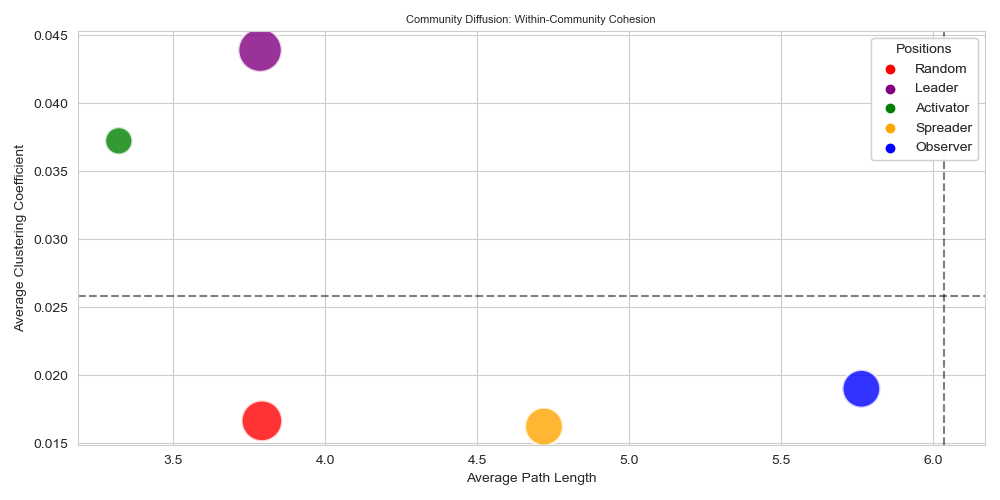

In [6]:
#COMMUNITY-ROLE DESCRIPTION
n=4
'''seed_dict = {"Random": r_lst,"Leader": l_lst, "Activator": a_lst, "Spreader": d_lst, "Observer": o_lst}
tot_com = len(set((df_vcomm_1['community_op']).to_list()))
#print(tot_com)
tot_nodes = G_dn1.number_of_nodes()
#print(tot_nodes)
avg_deg = np.mean((df_vcomm_1['strength']).to_list())
#print(avg_deg)

mean_pth = G_ig.average_path_length(directed=True)
mean_cls = G_ig.transitivity_avglocal_undirected()

dict_com={}
com_stat_lst = []
avg_com_stat_lst = []
for k,s in seed_dict.items():
    com_lst = set((df_vcomm_1['community_op'].loc[df_vcomm_1['id'].isin(s)]).to_list())
    #print(len(set(com_lst)))
    mem_lst = (df_vcomm_1['id'].loc[df_vcomm_1['community_op'].isin(com_lst)]).to_list()
    #print(len(mem_lst))
    
    s_id = [G_ig.vs.find(id=i).index for i in s]
    #print(k, s_id)
    #[1757, 1686, 106, 1764, 1475, 1378] 
    #path     
    pth_lst = G_ig.shortest_paths(source=s_id, weights='weight', mode='all')
       
    siz_c_lst = []
    den_c_lst = []
    deg_c_lst = []
    pth_c_lst = []
    cls_c_lst = []
    avg_deg_c_lst = []

    for com in com_lst:
        df_vc = df_vcomm_1.loc[df_vcomm_1["community_op"]==com]
        df_ec = df_ecomm_1.loc[df_ecomm_1["community_op"]==com]
        G_ig_c=ig.Graph.DictList(df_vc.to_dict('records'), df_ec.to_dict('records'), directed=False, vertex_name_attr='id', edge_foreign_keys=('source_', 'target_'))
        
        #size
        siz_c = G_ig_c.vcount()
        siz_c_lst.append(siz_c)  
        #density
        den_c = G_ig_c.density()
        den_c_lst.append(den_c)
        #path
        pth_c = G_ig_c.average_path_length(directed=True)
        pth_c_lst.append(pth_c)  
        #print(pth_c)
        #clustering
        cls_c = G_ig_c.transitivity_avglocal_undirected()
        cls_c_lst.append(cls_c)
        # degree
        deg_c = G_ig_c.strength(weights='weight', mode='all')
        avg_deg_c = np.mean(deg_c)
        avg_deg_c_lst.append(avg_deg_c)
        #print(siz_c_lst)
        #print(den_c_lst)
        #print(deg_c_lst)
        
        siz_k = siz_c/tot_nodes 
        com_stat = (k,siz_k,den_c,pth_c,cls_c)
        com_stat_lst.append(com_stat)
        
    tot_com_k = len(set(com_lst))
    tot_siz_k = np.sum(siz_c_lst)
    avg_den_k = np.mean(den_c_lst)
    avg_pth_k = np.mean(pth_c_lst)
    avg_deg_k = np.mean(avg_deg_c_lst)
    avg_cls_k = np.mean(cls_c_lst)
    
   
    avg_com_stat = (k,tot_com_k,tot_siz_k,avg_den_k,avg_pth_k,avg_cls_k)
    print(avg_com_stat)
    avg_com_stat_lst.append(avg_com_stat)
    
    
    #dict_com[k]=com_stat_lst
#print(dict_com)
#df_comk = pd.DataFrame(com_stat_lst, columns=['Positions','mem','den','cls'])
df_comk = pd.DataFrame(avg_com_stat_lst, columns=['Positions','tot_com','tot_mem','avg_den','avg_pth','avg_cls'])
#print(df_comk)


plt.rcParams["figure.figsize"]=[10,5]
c_role=['red','purple', 'green','orange','blue']
sns.set_palette(c_role)
sns.set_style("whitegrid")
#ax=sns.scatterplot(data=df_comk, y="cls", x="mem", hue="Positions", alpha=0.8)
ax=sns.scatterplot(data=df_comk, y="avg_cls", x="avg_pth", size="tot_com", hue="Positions", alpha=0.8, sizes=(400,1000))
x_line = plt.axvline(mean_pth, linestyle='--', color = 'black', alpha=0.5)
y_line = plt.axhline(mean_cls, linestyle='--', color = 'black', alpha=0.5)
plt.title('Community Diffusion: Within-Community Cohesion', fontsize=8)
plt.xlabel('Average Path Length')
plt.ylabel('Average Clustering Coefficient')
##legends
h,l = ax.get_legend_handles_labels()
col_lgd = plt.legend(h[1:6], l[1:6], loc='upper right', title='Positions')
plt.gca().add_artist(col_lgd)
plt.savefig("images_d_0/senekal_diff_("+str(n)+")_3a.png")
plt.show()'''
  
    
'''
('Random', 5, 480, 0.02935986902138535, 5.4917686150128375, 0.016637645907046063)
('Leader', 6, 573, 0.027173849295706053, 4.392236822232292, 0.04388872949910958)
('Activator', 1, 150, 0.01888143176733781, 4.130040779338469, 0.03722334004024145)
('Spreader', 4, 290, 0.037124816431334626, 5.124754568796254, 0.016222720148665527)
('Observer', 4, 188, 0.06134583837588953, 10.609198006343453, 0.018996598639455783)
------
('Random', 5, 480, 0.02935986902138535, 3.7923414477781563, 0.016637645907046063)
('Leader', 6, 573, 0.027173849295706053, 3.786304195427517, 0.04388872949910958)
('Activator', 1, 150, 0.01888143176733781, 3.3217897091722595, 0.03722334004024145)
('Spreader', 4, 290, 0.037124816431334626, 4.719771439537607, 0.016222720148665527)
('Observer', 4, 188, 0.06134583837588953, 5.763465407319307, 0.018996598639455783)
'''

#----
plt.close()
#----
Image(filename="images_d_0/senekal_diff_(4)_3a.png",  width = "650")
#6 5, 1 4 4

#### 1.2. Diffusion In and Out Community



To estimate the daily spread of an infection, I simulate the diffusion process of each initial seed in each role and compare the ratio of infected nodes within community and outside community across early and late-stage diffusion. For this network, early stage refers to all infections (adoptions) before 16 October 2020 and late stage are all infections (adoptions) up to to 31 May 2021. 

In [7]:
##COMMUNITY DIFFUSION
#PRE-PEAK
#output_notebook()
# Model selection - ProfileThresholdModel
#model_pt = ep.ProfileThresholdModel(G_nx)
#print(r_lst)
'''val_lst=[]
val_lst_x=[]
seed2_dict = {"Random": r2_lst, "Leader": l2_lst, "Activator": a2_lst, "Spreader": d2_lst, "Observer": o2_lst}
#seed_dict = {1: l_lst, 2: a_lst, 3: d_lst, 4: o_lst}
for k,s in seed2_dict.items():
    #print(k)

    for r_iter in range(0,100):
        #print(r_iter)
        #print(s)
        com_lst = (df_vcomm_1['community_op'].loc[df_vcomm_1['id'].isin(s)]).to_list()
        #print(com_lst)
        #print(set(com_lst))
        mem_lst = (df_vcomm_1['id'].loc[df_vcomm_1['community_op'].isin(com_lst)]).to_list()
        #print(mem_lst)

        model = dm.DynProfileThresholdModel(G_dn2)

        # Model Configuration
        config = mc.Configuration()
        #config.add_model_parameter('percentage_infected', 0.01)
        config.add_model_parameter('adopter_rate', adopt)
        config.add_model_parameter('percentage_blocked', block)
        config.add_model_initial_configuration('Infected', s)

        # Setting node parameters
        for i in G_dn2.nodes():
            config.add_node_configuration("threshold", i, threshold)
            config.add_node_configuration("profile", i, profile)
        model.set_initial_status(config)

        # Simulation execution
        iterations = model.execute_snapshots()
        #iterations = model_pt.iteration_bunch(n)
        trends = model.build_trends(iterations)
        #print(len(iterations)) #15

        in_com_prev=0
        out_com_prev=0
        #print(len(iterations))
        for it in iterations:
            t=it['iteration']
            #print("iter:", it['iteration'])
            infected = len([v for k,v in it['status'].items() if v==1])
            in_com_lst = [id_key for id_key, val in it['status'].items() if id_key in mem_lst and val==1] 
            out_com_lst = [id_key for id_key, val in it['status'].items() if id_key not in mem_lst and val==1] 

            if infected > 0:
                in_com = (len(in_com_lst)/infected)+in_com_prev
                out_com = (len(out_com_lst)/infected)+out_com_prev
                #print(in_com,out_com)
            else:
                in_com = in_com_prev
                out_com = out_com_prev   
                #print(in_com,out_com)
                
            in_com_prev = in_com
            out_com_prev = out_com

            tmp = (k,t,in_com,out_com)
            val_lst.append(tmp) 
            #print(val_lst) 
            
            if t==len(iterations)-1:
                #print(t)
                #print(tmp)
                val_lst_x.append(tmp)

df_c_2 = pd.DataFrame(val_lst, columns=['Positions','Iterations','in_com','out_com'])
#print(df_c)
df_c_x_2 = pd.DataFrame(val_lst_x, columns=['Positions','Iterations','in_com','out_com'])
#print(df_c_x)'''

#---- 
plt.close()
#---- 

In [8]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '1 October 2020 - 15 October 2020' + "\n")
print('\033[1m' +"Parameters:" + '\033[0m')
print("a. "+ str(no_leader2) + " Randoms Infected")
print("b. "+ str(no_leader2) + " Leaders Infected") 
print("c. "+ str(no_activator2) +  " Activators Infected") 
print("d. "+ str(no_spreader2) + " Spreaders Infected")
print("e. "+ str(no_observer2) + " Observers Infected")

--------
Period: 1 October 2020 - 15 October 2020

Parameters:
a. 2 Randoms Infected
b. 2 Leaders Infected
c. 0 Activators Infected
d. 2 Spreaders Infected
e. 2 Observers Infected


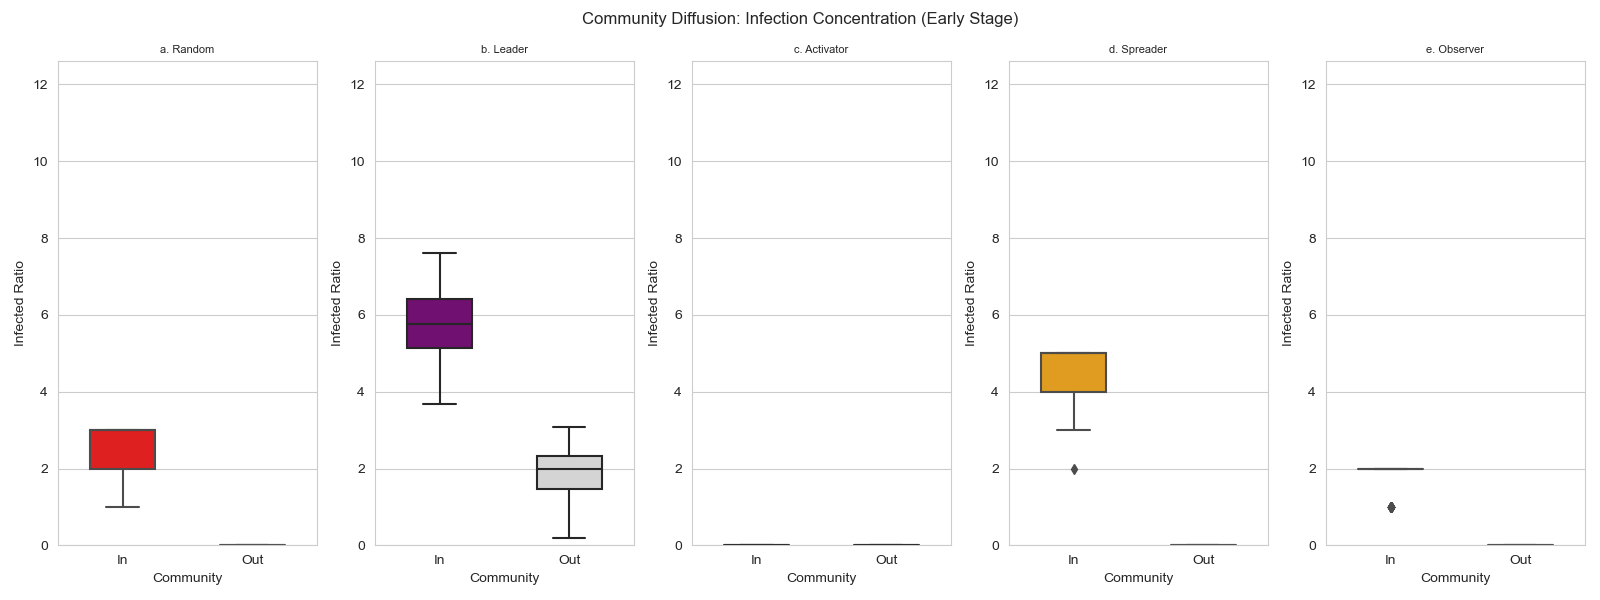

In [9]:
#Within/Between Diffusion Plot
'''c_crole=[['red','#D4D4D4'], ['purple','#D4D4D4'], ['green','#D4D4D4'],['orange','#D4D4D4'],['blue','#D4D4D4']]
r_role = ["a. Random","b. Leader","c. Activator","d. Spreader","e. Observer"]
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"]=[16,6]
df_col = df_c_x_2.rename(columns={'in_com':'In', 'out_com':'Out'})
max_y = max(df_col['In'].max(),df_col['Out'].max())
#print(df_c_x)
df_c_long = pd.melt(df_col, id_vars='Positions', value_vars=['In','Out'])
for i,r in enumerate(seed_dict.keys()):
    sns.set_palette(c_crole[i])
    df_c_long_x = df_c_long.loc[df_c_long['Positions']==r]
    plt.subplot(1,5,i+1)
    sns.boxplot(data=df_c_long_x, x="variable", y='value', width=0.5)
    plt.title(r_role[i], fontsize=8)
    plt.ylim(0,max_y+5)
    plt.ylabel('Infected Ratio')
    plt.xlabel('Community')
plt.suptitle('Community Diffusion: Infection Concentration (Early Stage)', fontsize=12)    
plt.savefig("images_d_0/senekal_diff_("+str(n)+")_4a.png")
plt.show()'''

#---- 
plt.close()
#----     
Image(filename="images_d_0/senekal_diff_(3)_4a.png",  width = "850")

In [10]:
##COMMUNITY DIFFUSION
#FULL PERIOD
#output_notebook()
# Model selection - ProfileThresholdModel
#model_pt = ep.ProfileThresholdModel(G_nx)
#print(len(n1_lst))
#print(r_lst)
'''val_lst=[]
val_lst_x=[]
#seed_dict = {1: l_lst, 2: a_lst, 3: d_lst, 4: o_lst}
for k,s in seed_dict.items():
    #print(k)    
    for r_iter in range(0,100):
        #print(r_iter)
        #print(s)

        model = dm.DynProfileThresholdModel(G_dn1)
        
    
        # Model Configuration
        config = mc.Configuration()
        #config.add_model_parameter('percentage_infected', 0.01)
        config.add_model_parameter('adopter_rate', adopt)
        config.add_model_parameter('percentage_blocked', block)
        config.add_model_initial_configuration('Infected', s)

        # Setting node parameters
        for i in G_dn1.nodes():
            config.add_node_configuration("threshold", i, threshold)
            config.add_node_configuration("profile", i, profile)
        model.set_initial_status(config)

        # Simulation execution
        iterations = model.execute_snapshots()
        #iterations = model_pt.iteration_bunch(n)
        trends = model.build_trends(iterations)
        #print(len(iterations)) #165
        
        com_lst = (df_vcomm_1['community_op'].loc[df_vcomm_1['id'].isin(s)]).to_list()
        #print(com_lst)
        #print(set(com_lst))
        mem_lst = (df_vcomm_1['id'].loc[df_vcomm_1['community_op'].isin(com_lst)]).to_list()
        #print(mem_lst)
        
        in_com_prev=0
        out_com_prev=0
        #print(len(iterations))
        for it in iterations:
            t=it['iteration']
            #print("iter:", it['iteration'])
            infected = len([v for k,v in it['status'].items() if v==1])
            in_com_lst = [id_key for id_key, val in it['status'].items() if id_key in mem_lst and val==1] 
            out_com_lst = [id_key for id_key, val in it['status'].items() if id_key not in mem_lst and val==1] 

            if infected > 0:
                in_com = (len(in_com_lst)/infected)+in_com_prev
                out_com = (len(out_com_lst)/infected)+out_com_prev
                #print(in_com,out_com)
            else:
                in_com = in_com_prev
                out_com = out_com_prev   
                #print(in_com,out_com)

            in_com_prev = in_com
            out_com_prev = out_com

            tmp = (k,t,in_com,out_com)
            val_lst.append(tmp) 
            #print(val_lst) 

            if t==len(iterations)-1:
                #print(t)
                #print(tmp)
                val_lst_x.append(tmp)

df_c = pd.DataFrame(val_lst, columns=['Positions','Iterations','in_com','out_com'])
#print(df_c)
df_c_x = pd.DataFrame(val_lst_x, columns=['Positions','Iterations','in_com','out_com'])
#print(df_c_x)'''

#---- 
plt.close()
#---- 

In [11]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '1 October 2020 - 31 May 2021' + "\n")
print('\033[1m' +"Parameters:" + '\033[0m')
print("a. "+ str(no_leader) + " Randoms Infected")
print("b. "+ str(no_leader) + " Leaders Infected") 
print("c. "+ str(no_activator) +  " Activators Infected") 
print("d. "+ str(no_spreader) + " Spreaders Infected")
print("e. "+ str(no_observer) + " Observers Infected")

--------
Period: 1 October 2020 - 31 May 2021

Parameters:
a. 6 Randoms Infected
b. 6 Leaders Infected
c. 1 Activators Infected
d. 6 Spreaders Infected
e. 6 Observers Infected


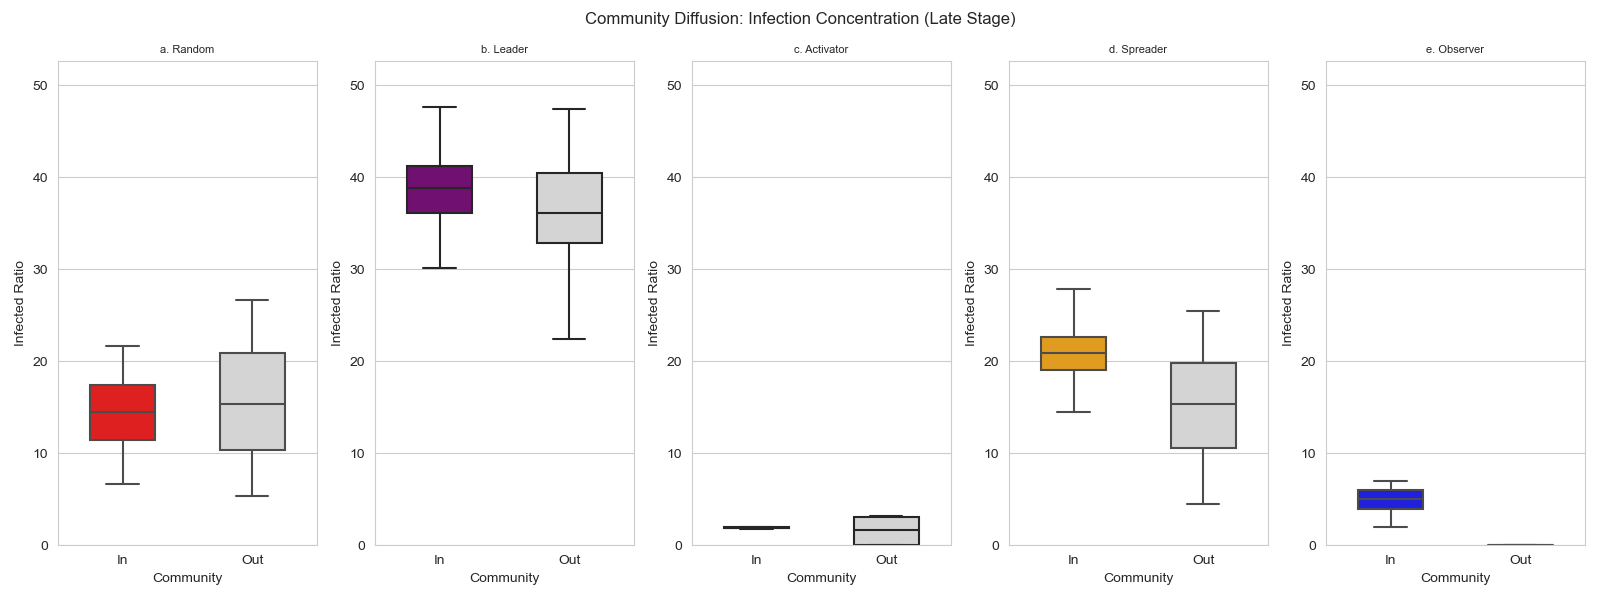

In [12]:
#Within/Between Diffusion Plot
'''sns.set_style("whitegrid")
plt.rcParams["figure.figsize"]=[16,6]
df_col = df_c_x.rename(columns={'in_com':'In', 'out_com':'Out'})
max_y = max(df_col['In'].max(),df_col['Out'].max())
#print(df_c_x)
df_c_long = pd.melt(df_col, id_vars='Positions', value_vars=['In','Out'])
for i,r in enumerate(seed_dict.keys()):
    sns.set_palette(c_crole[i])
    df_c_long_x = df_c_long.loc[df_c_long['Positions']==r]
    plt.subplot(1,5,i+1)
    sns.boxplot(data=df_c_long_x, x="variable", y='value', width=0.5)
    plt.title(r_role[i], fontsize=8)
    plt.ylim(0,max_y+5)
    plt.ylabel('Infected Ratio')
    plt.xlabel('Community')
plt.suptitle('Community Diffusion: Infection Concentration (Late Stage)', fontsize=12)    
plt.savefig("images_d_0/senekal_diff_("+str(n)+")_4b.png")
plt.show()'''
#---- 
plt.close()
#----     
Image(filename="images_d_0/senekal_diff_(3)_4b.png",  width = "850")

In [13]:
##Role Model
#output_notebook()
# Model selection - ProfileThresholdModel
#model_pt = ep.ProfileThresholdModel(G_nx)
#seed_dict = {0:r_lst, 1: l_lst, 2: a_lst, 3: d_lst, 4: o_lst}
'''for k,s in seed_dict.items():
    model = dm.DynProfileThresholdModel(G_dn)

    # Model Configuration
    config = mc.Configuration()
    #config.add_model_parameter('percentage_infected', 0.01)
    config.add_model_parameter('adopter_rate', adopt)
    config.add_model_parameter('percentage_blocked', block)
    config.add_model_initial_configuration('Infected', s)

    # Setting node parameters
    for i in G_dn.nodes():
        config.add_node_configuration("threshold", i, threshold)
        config.add_node_configuration("profile", i, profile)
    model.set_initial_status(config)

    # Simulation execution
    iterations = model.execute_snapshots()
    #iterations = model_pt.iteration_bunch(n)
    trends = model.build_trends(iterations)
    
    # Visualise Diffusion
    viz_t = DiffusionTrend(model, trends)
    viz_t.plot("images_d_0/"+str(k)+"_senekal_diff_"+ str(n) +"_1a.svg", statuses=["Infected"], percentile=90)

    viz_p = DiffusionPrevalence(model, trends)
    viz_p.plot("images_d_0/"+str(k)+"_senekal_diff_"+ str(n) +"_2a.svg")
    #show(l)


    #Export
    #iterations.write_snapshots()
    dict_st={}
    id_st={}
    #print(iterations)

    for it in iterations:
        #print(it['iteration'])
        id_st = {innerKey:values for innerKey, values in it['status'].items()} 
        dict_st[it['iteration']] = id_st            
        #print(dict_st)
    df_st = pd.DataFrame(dict_st)
    #print(df_st)

    i=0
    u=301
    v=len(iterations)
    df_st['infect_'+str(k)] = df_st[i]
    df_st['iter_'+ str(k)+'_'+str(i+1)] = df_st.iloc[:, i+1:u].sum(axis=1, skipna=True) - df_st[i]
    for i in range(2,4):
        #print(i)
        df_st['iter_'+str(k)+'_'+str(i)] = df_st.iloc[:, u:u+100].sum(axis=1, skipna=True) - df_st.iloc[:, 0:u].sum(axis=1, skipna=True)
        i+=1
        u+=100
    df_st['end_'+str(k)] = df_st.iloc[:, v:v+1].sum(axis=1, skipna=True) - df_st.iloc[:, 0:v].sum(axis=1, skipna=True)

    df_st = df_st.loc[:, 'infect_'+ str(k):'end_'+ str(k)].reset_index(drop=False)

    df_st.to_csv("senekal_diff_"+ str(k)+".csv", sep=";",encoding='utf-8',  index=False)
    '''
    
#----

plt.close()
#----

----------------------------------------------------------
#### 2. POSITIONAL DIFFUSION 


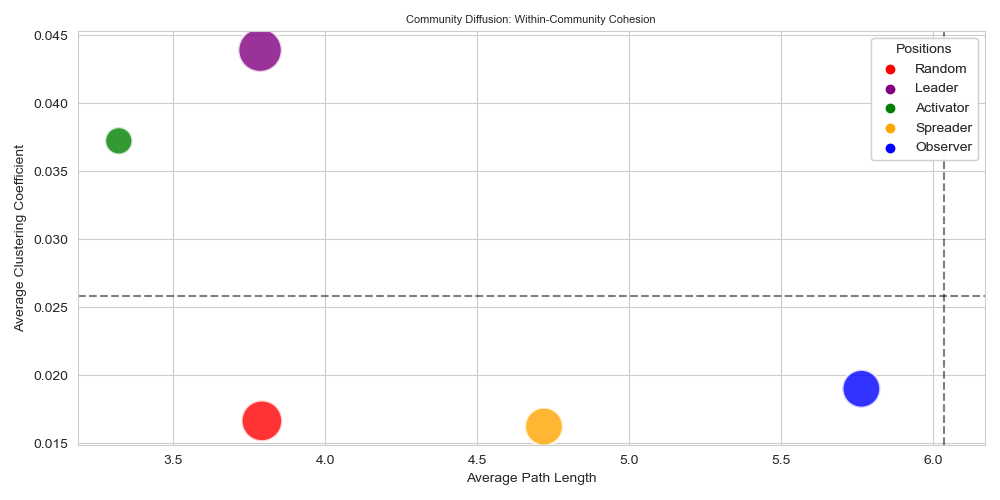

In [6]:
#COMMUNITY-ROLE DESCRIPTION
n=4
seed_dict = {"Random": r_lst,"Leader": l_lst, "Activator": a_lst, "Spreader": d_lst, "Observer": o_lst}
tot_com = len(set((df_vcomm_1['community_op']).to_list()))
#print(tot_com)
tot_nodes = G_dn1.number_of_nodes()
#print(tot_nodes)
avg_deg = np.mean((df_vcomm_1['strength']).to_list())
#print(avg_deg)

mean_pth = G_ig.average_path_length(directed=True)
mean_cls = G_ig.transitivity_avglocal_undirected()

dict_com={}
com_stat_lst = []
avg_com_stat_lst = []
for k,s in seed_dict.items():
    com_lst = set((df_vcomm_1['community_op'].loc[df_vcomm_1['id'].isin(s)]).to_list())
    #print(len(set(com_lst)))
    mem_lst = (df_vcomm_1['id'].loc[df_vcomm_1['community_op'].isin(com_lst)]).to_list()
    #print(len(mem_lst))
    
    s_id = [G_ig.vs.find(id=i).index for i in s]
    #print(k, s_id)
    #[1757, 1686, 106, 1764, 1475, 1378] 
    #path     
    pth_lst = G_ig.shortest_paths(source=s_id, weights='weight', mode='all')
       
    siz_c_lst = []
    den_c_lst = []
    deg_c_lst = []
    pth_c_lst = []
    cls_c_lst = []
    avg_deg_c_lst = []

    for com in com_lst:
        df_vc = df_vcomm_1.loc[df_vcomm_1["community_op"]==com]
        df_ec = df_ecomm_1.loc[df_ecomm_1["community_op"]==com]
        G_ig_c=ig.Graph.DictList(df_vc.to_dict('records'), df_ec.to_dict('records'), directed=False, vertex_name_attr='id', edge_foreign_keys=('source_', 'target_'))
        
        #size
        siz_c = G_ig_c.vcount()
        siz_c_lst.append(siz_c)  
        #density
        den_c = G_ig_c.density()
        den_c_lst.append(den_c)
        #path
        pth_c = G_ig_c.average_path_length(directed=True)
        pth_c_lst.append(pth_c)  
        #print(pth_c)
        #clustering
        cls_c = G_ig_c.transitivity_avglocal_undirected()
        cls_c_lst.append(cls_c)
        # degree
        deg_c = G_ig_c.strength(weights='weight', mode='all')
        avg_deg_c = np.mean(deg_c)
        avg_deg_c_lst.append(avg_deg_c)
        #print(siz_c_lst)
        #print(den_c_lst)
        #print(deg_c_lst)
        
        siz_k = siz_c/tot_nodes 
        com_stat = (k,siz_k,den_c,pth_c,cls_c)
        com_stat_lst.append(com_stat)
        
    tot_com_k = len(set(com_lst))
    tot_siz_k = np.sum(siz_c_lst)
    avg_den_k = np.mean(den_c_lst)
    avg_pth_k = np.mean(pth_c_lst)
    avg_deg_k = np.mean(avg_deg_c_lst)
    avg_cls_k = np.mean(cls_c_lst)
    
   
    avg_com_stat = (k,tot_com_k,tot_siz_k,avg_den_k,avg_pth_k,avg_cls_k)
    print(avg_com_stat)
    avg_com_stat_lst.append(avg_com_stat)
    
    
    #dict_com[k]=com_stat_lst
#print(dict_com)
#df_comk = pd.DataFrame(com_stat_lst, columns=['Positions','mem','den','cls'])
df_comk = pd.DataFrame(avg_com_stat_lst, columns=['Positions','tot_com','tot_mem','avg_den','avg_pth','avg_cls'])
#print(df_comk)


plt.rcParams["figure.figsize"]=[10,5]
c_role=['red','purple', 'green','orange','blue']
sns.set_palette(c_role)
sns.set_style("whitegrid")
#ax=sns.scatterplot(data=df_comk, y="cls", x="mem", hue="Positions", alpha=0.8)
ax=sns.scatterplot(data=df_comk, y="avg_cls", x="avg_pth", size="tot_com", hue="Positions", alpha=0.8, sizes=(400,1000))
x_line = plt.axvline(mean_pth, linestyle='--', color = 'black', alpha=0.5)
y_line = plt.axhline(mean_cls, linestyle='--', color = 'black', alpha=0.5)
plt.title('Community Diffusion: Within-Community Cohesion', fontsize=8)
plt.xlabel('Average Path Length')
plt.ylabel('Average Clustering Coefficient')
##legends
h,l = ax.get_legend_handles_labels()
col_lgd = plt.legend(h[1:6], l[1:6], loc='upper right', title='Positions')
plt.gca().add_artist(col_lgd)
plt.savefig("images_d_0/senekal_diff_("+str(n)+")_3a.png")
plt.show()'''
  
    
'''
('Random', 5, 480, 0.02935986902138535, 5.4917686150128375, 0.016637645907046063)
('Leader', 6, 573, 0.027173849295706053, 4.392236822232292, 0.04388872949910958)
('Activator', 1, 150, 0.01888143176733781, 4.130040779338469, 0.03722334004024145)
('Spreader', 4, 290, 0.037124816431334626, 5.124754568796254, 0.016222720148665527)
('Observer', 4, 188, 0.06134583837588953, 10.609198006343453, 0.018996598639455783)
------
('Random', 5, 480, 0.02935986902138535, 3.7923414477781563, 0.016637645907046063)
('Leader', 6, 573, 0.027173849295706053, 3.786304195427517, 0.04388872949910958)
('Activator', 1, 150, 0.01888143176733781, 3.3217897091722595, 0.03722334004024145)
('Spreader', 4, 290, 0.037124816431334626, 4.719771439537607, 0.016222720148665527)
('Observer', 4, 188, 0.06134583837588953, 5.763465407319307, 0.018996598639455783)
'''

#----
plt.close()
#----
Image(filename="images_d_0/senekal_diff_(4)_3a.png",  width = "650")
#6 5, 1 4 4


To simulate the rate and extent of possible diffusion in peak discourse, I trace and plot multiple diffusion trends by assigning specific users from each role as initial seeds. I also visualise a snapshot graph showing the infection rate for each simulation from interactions on 16 October 2020. A community layout is applied to the snapshot graph so that users are mapped within their detected community.



#### 2.1. Random Seed Infection

In [14]:
#print("\n" + "--------" + "\n" + '\033[1m' + 'Random Diffusion:' + '\033[0m' + "\n")
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '16 October 2020 00:00:00 - 16 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ '\033[0m' + str(format(leader*100,'.2f')) + "%" + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_leader) + ' Randoms Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '33 Users Infected')


--------
Period: 16 October 2020 00:00:00 - 16 October 2020 23:59:59

Parameters: 0.84% Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 6 Randoms Infected

End: 33 Users Infected


--------
Random Diffusion Trend



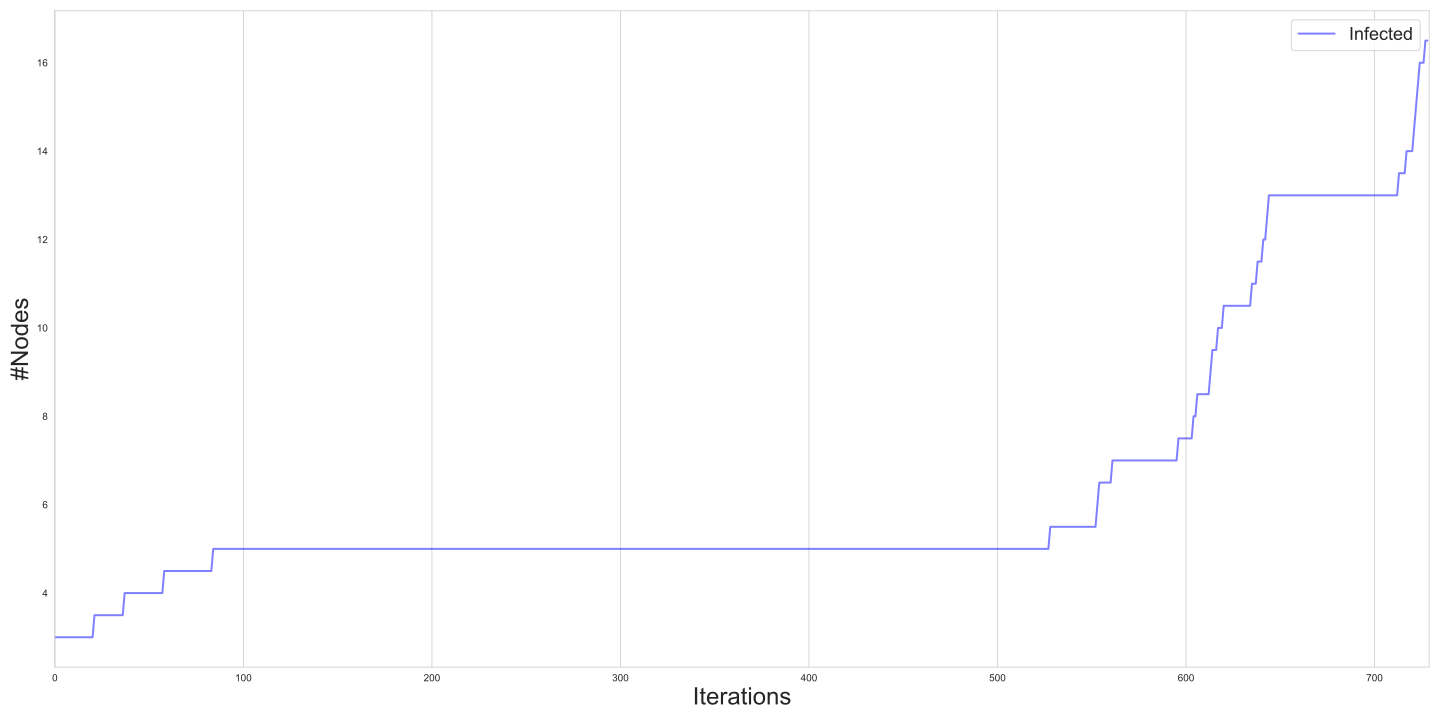

In [15]:
#
print("--------" + "\n" + '\033[1m' +"Random Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\0_senekal_diff_1_1a.svg"))

--------
Random Diffusion Infected



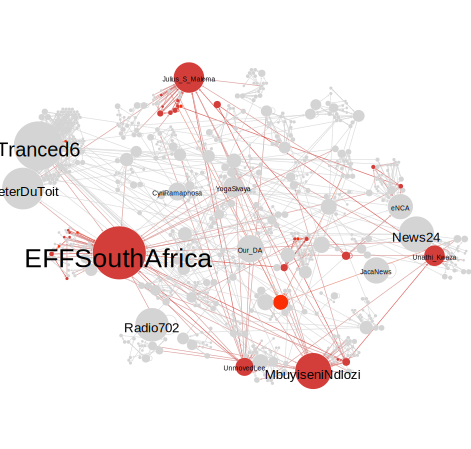

In [16]:
print("--------" + "\n" + '\033[1m' +"Random Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\0_senekal_diff_r.svg"))

#### 2.2. Leader Seed Infection

In [17]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '16 October 2020 00:00:00 - 16 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ '\033[0m' + str(format(leader*100,'.2f')) + "% " + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_leader) + ' Leaders Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '159 Users Infected')

--------
Period: 16 October 2020 00:00:00 - 16 October 2020 23:59:59

Parameters: 0.84%  Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 6 Leaders Infected

End: 159 Users Infected


--------
Leader Diffusion Trend



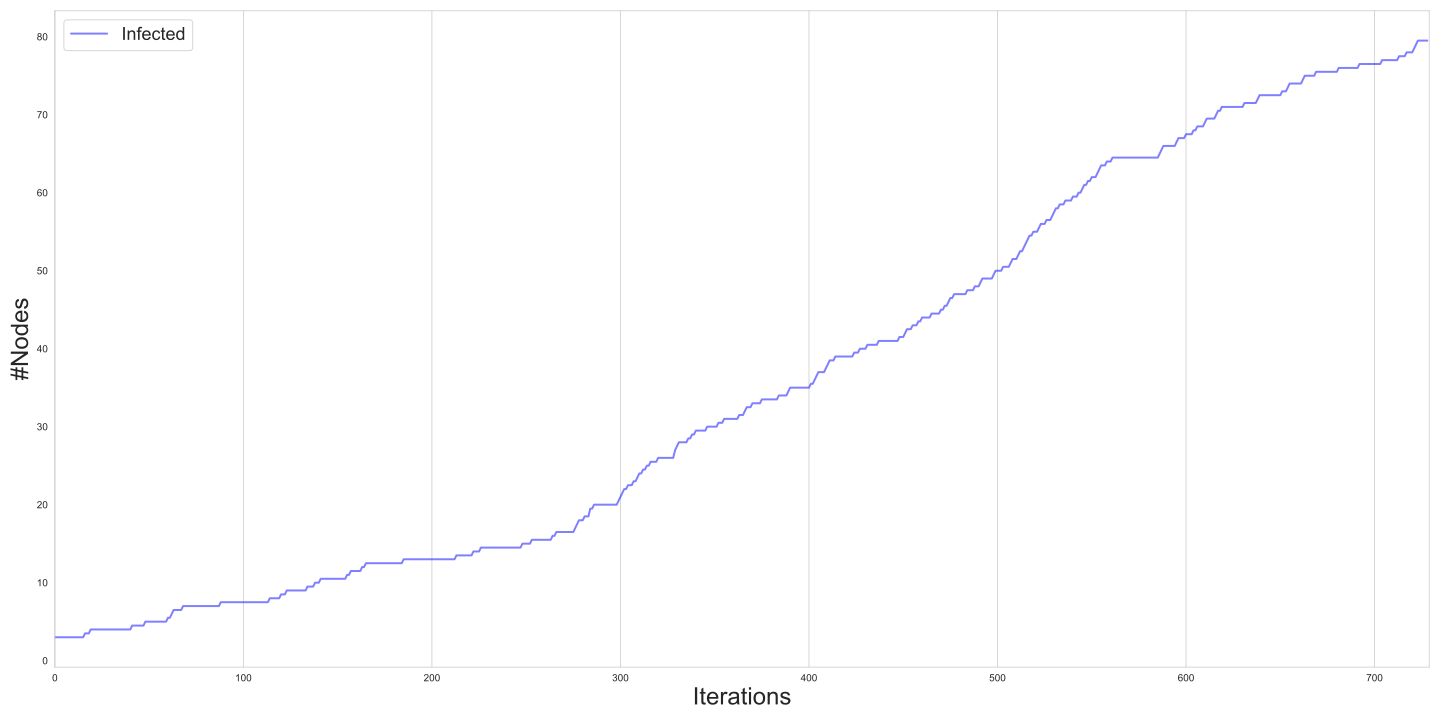

In [18]:
#
print("--------" + "\n" + '\033[1m' +"Leader Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\1_senekal_diff_0_1a.svg"))

--------
Leader Diffusion Infected



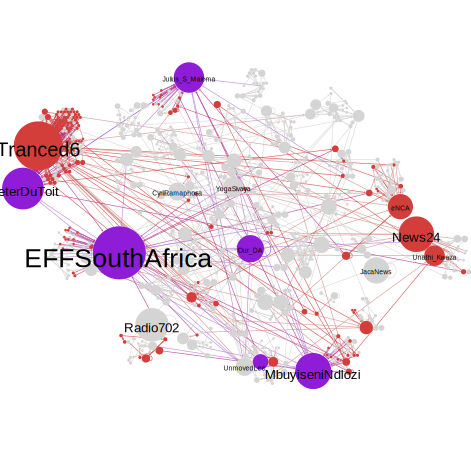

In [19]:
print("--------" + "\n" + '\033[1m' +"Leader Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\1_senekal_diff_l.svg"))

#### 2.3. Activator Seed Infection

In [20]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '16 October 2020 00:00:00 - 16 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ '\033[0m' + str("{:.2f}".format(activator*100)) + "% " + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_activator) + ' Activator Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '83 Users Infected')

--------
Period: 16 October 2020 00:00:00 - 16 October 2020 23:59:59

Parameters: 0.14%  Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 1 Activator Infected

End: 83 Users Infected


--------
Activator Diffusion Trend



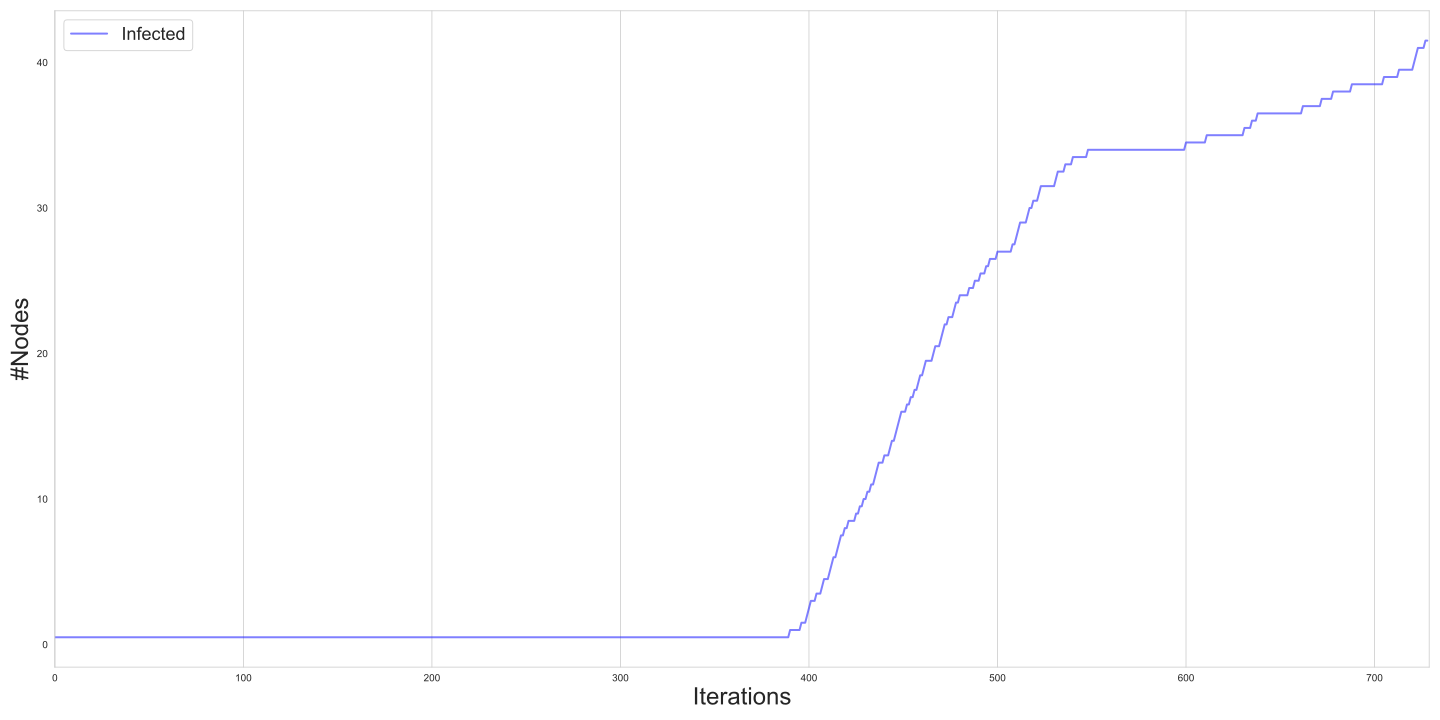

In [21]:
#
print("--------" + "\n" + '\033[1m' +"Activator Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\2_senekal_diff_0_1a.svg"))

--------
Activator Diffusion Infected



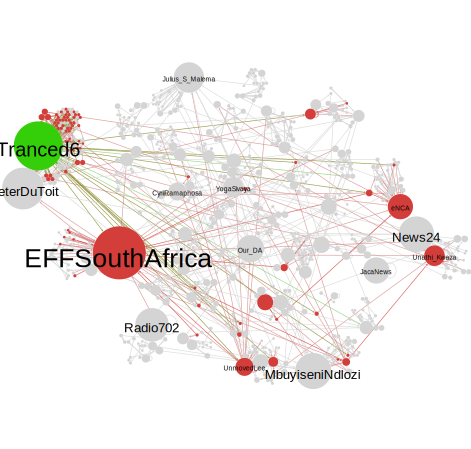

In [22]:
print("--------" + "\n" + '\033[1m' +"Activator Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\2_senekal_diff_a.svg"))

#### 2.4. Spreader Seed Infection

In [23]:
print("--------" + "\n" + '\033[1m' +"Period :"+ '\033[0m' + '16 October 2020 00:00:00 - 16 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters :"+ '\033[0m' + str("{:.2f}".format(spreader*100)) + "% " + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_spreader) + ' Spreaders Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '127 Users Infected')

--------
Period :16 October 2020 00:00:00 - 16 October 2020 23:59:59

Parameters :0.84%  Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 6 Spreaders Infected

End: 127 Users Infected


--------
Spreader Diffusion Trend



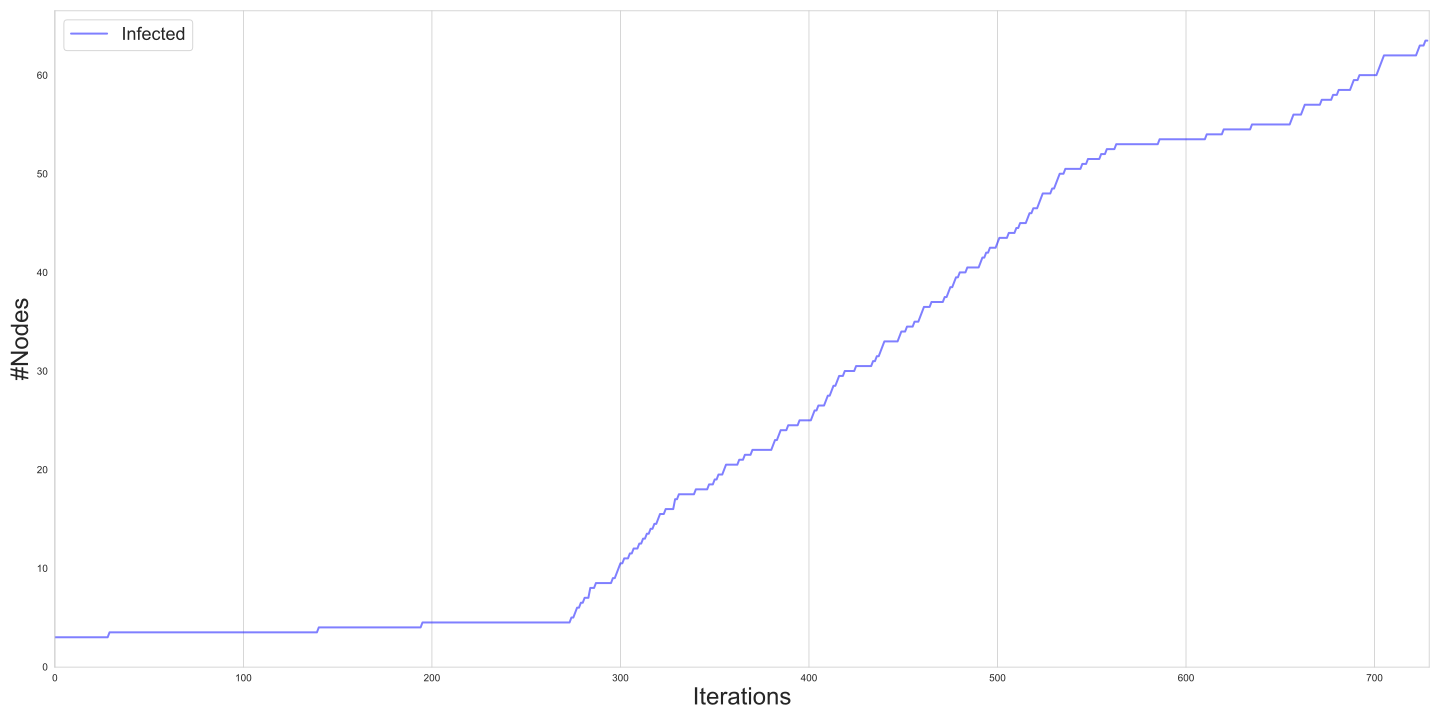

In [24]:
#

print("--------" + "\n" + '\033[1m' +"Spreader Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\3_senekal_diff_0_1a.svg"))

--------
Spreader Diffusion Infected



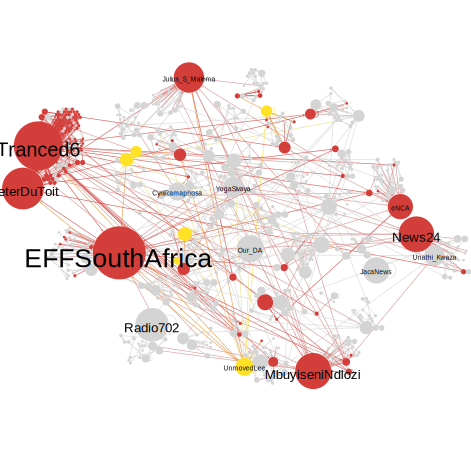

In [25]:
print("--------" + "\n" + '\033[1m' +"Spreader Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\3_senekal_diff_d.svg"))

#### 2.5. Observer Seed Infection

In [26]:
print("--------" + "\n" + '\033[1m' +"Period: "+ '\033[0m' + '16 October 2020 00:00:00 - 16 October 2020 23:59:59' + "\n")
print('\033[1m' +"Parameters: "+ str('\033[0m' + "{:.2f}".format(observer*100)) + "% " + " Infected, " + str(profile*100) + "% Profile, " + str(threshold*100) + "% Threshold, " + str(block*100) + "% Blocked." + "\n")
print('\033[1m' +"Start: "+ '\033[0m' + str(no_observer) + ' Observers Infected' + "\n")
print('\033[1m' +"End: "+ '\033[0m' + '9 Users Infected')

--------
Period: 16 October 2020 00:00:00 - 16 October 2020 23:59:59

Parameters: 0.84%  Infected, 25.0% Profile, 60.0% Threshold, 0% Blocked.

Start: 6 Observers Infected

End: 9 Users Infected


--------
Observer Diffusion Trend



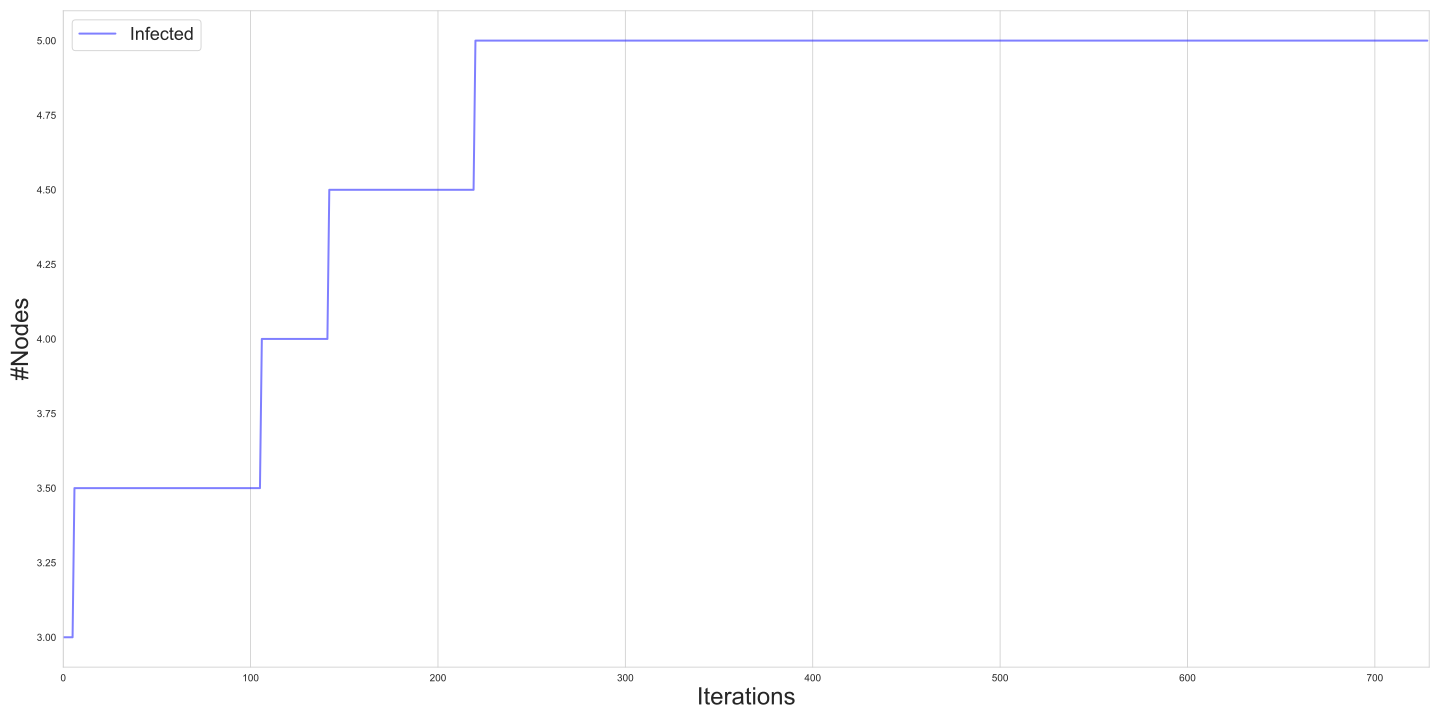

In [27]:
#

print("--------" + "\n" + '\033[1m' +"Observer Diffusion Trend"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\4_senekal_diff_0_1a.svg"))

--------
Observer Diffusion Infected



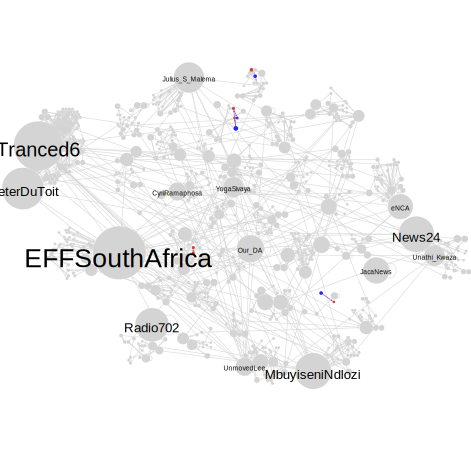

In [28]:
print("--------" + "\n" + '\033[1m' +"Observer Diffusion Infected"+ '\033[0m' + "\n")
display(SVG(filename="images_d_0\\4_senekal_diff_o.svg"))

----------------------------------------------------------------
#### 3. SUMMARY 



In this section, I simulate multiple diffusion processes and make inferences about the people, positions and groups that have the potential to effectively spread information and incite widespread discourse in the #Senekal twitter reply network.    

To explore the link between community cohesion and diffusion, I match eligible seeds to the communities they are contained in and map the average path length and clustering coefficient of each role. I find 6 seperate communities containing seeds from the *Leader* role, 5 communities containing *Random* seeds, 4 communities matching seeds from *Spreader* and *Observer* roles, respectively, and a single seed and community contained in the *Activator* role. The cohesion plot shows that communities that contain *Observer* seeds have the highest average path length, while the community that contains the *Activator* seed has the lowest. *Leader* communities have the highest clustering coefficient and *Random* and *Spreader* communities have the lowest. Assuming redundant ties are reinforcing, *Leader* seeds are best placed to outperform.

The diffusion performance of seeds in each role are represented by boxplots. I find *Leader* seeds successfully permeating both within and outside communities in both early-stage and late-stage diffusion, achieving the highest infection rates in both stages of the simulation. *Spreader* seeds are second highest in performance, with *Random* seed performance falling slightly behind. The worst performing diffusers in this network are *Activator* and *Observer* seeds. Some interesting observations are noted from these simulations. The *Activator* seed, although recording high clustering and low average distance features, is amongst the worst performers. This can however be attributed to the fact that only one node is assigned to the *Activator* role, and therefore lacks the power to infect many users outside its community and across the network. Furthermore, *Spreader* seeds maintain a slight advantage over *Random* seeds even though *Random* seed communities measure relatively lower average path lengths. This suggests, more than anything, when deciding which role is most effective in inciting a diffusion process, the type of features exhibited by specific users in a particular role are the most important factors to consider. In this case leader properties are key. The overall diffusion process shows that higher levels of infection are achieved within-community than outside community. These results are consistent with complex contagion where redundant ties are leveraged to achieve greater virality. 
 
As an additional step, I examine the outcome of diffusion during peak discourse (i.e. the day with the highest interaction of tweet replies). In these simulations, users are assumed to be tweeting in real time. From the first tweet response to the last, I trace and plot the infection trend and visualise the spread at specific points throughout the day. The results are consistent with those found earlier. *Leader* diffusion is the most expansive in reach, followed by *Spreader*, *Activator*, *Random*, and lastly, *Observer* seeds. The network snapshots show *Leader* seeds to achieve higher and faster penetration throughout the network relative to seeds in other roles. The diffusion trends show *Spreader* and *Activator* seeds starting off slow before attaining enough support (probably as more users come online to reply to tweets). *Random* and *Observer* seeds, however, seem to either take too long to gain momentum or fail to break out of the trap entirely.

This excercise in diffusion mechanics shows three main things: (i) the identification of key users and roles is critical in promoting the adoption of a new idea or behaviour within and across communities, (ii) early-stage diffusion is a strong indicator of late-stage diffusion, and (iii) close knit communities act as a social reinforcement mechanism that can accelerate the spread of a new idea or behaviour.
